# Dataset preparing 

In [42]:
'''
Load libs
'''
import torch
import torchvision as tv
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, transform

plt.style.use('ggplot')
np.random.seed(42)

In [2]:
'''
Define data folders 
'''
train_dir = './data/train'
test_dir = './data/test'

train_images_dir = os.path.join(train_dir, 'images')
train_masks_dir = os.path.join(train_dir, 'masks')

test_images_dir = os.path.join(test_dir, 'images')
test_masks_dir = os.path.join(test_dir, 'masks')

imageinfo_filename = './ISIC/imagedata.csv' # Info for all images 
maskinfo_filename = './ISIC/masksdata.csv'

In [3]:
'''
Load metadata
'''
image_info = pd.read_csv(imageinfo_filename)
mask_info = pd.read_csv(maskinfo_filename)

print('Datasets:')
print(list(image_info['dataset_name'].unique()))

Datasets:
['UDA-1', 'UDA-2', 'MSK-2', 'MSK-1', 'MSK-3', 'MSK-4', 'MSK-5', 'Dermoscopedia (CC-BY)', '2018 JID Editorial Images', 'HAM10000']


In [17]:
def show_imgmask(img, mask, ax=None, title=''):
    if ax:
        ax.imshow(img)
        ax.imshow(mask, alpha=0.3)
    else:
        plt.imshow(img)
        plt.imshow(mask, alpha=0.3)
        plt.axis('off')
        plt.title(title)
        plt.show()

In [15]:
image_info.head()

,isic_name,isic_id,age_approx,anatom_site_general,benign_malignant,clin_size_long_diam_mm,diagnosis,diagnosis_confirm_type,family_hx_mm,mel_class,mel_thick_mm,melanocytic,nevus_type,personal_hx_mm,sex,dataset_name
0,ISIC_0000000,5436e3abbae478396759f0cf,55.0,anterior torso,benign,NaN,nevus,NaN,NaN,NaN,NaN,True,NaN,NaN,female,UDA-1
1,ISIC_0000001,5436e3acbae478396759f0d1,30.0,anterior torso,benign,NaN,nevus,NaN,NaN,NaN,NaN,True,NaN,NaN,female,UDA-1
2,ISIC_0000002,5436e3acbae478396759f0d3,60.0,upper extremity,malignant,NaN,melanoma,histopathology,NaN,NaN,NaN,True,NaN,NaN,female,UDA-1
3,ISIC_0000003,5436e3acbae478396759f0d5,30.0,upper extremity,benign,NaN,nevus,NaN,NaN,NaN,NaN,True,NaN,NaN,male,UDA-1
4,ISIC_0000004,5436e3acbae478396759f0d7,80.0,posterior torso,malignant,NaN,melanoma,histopathology,NaN,NaN,NaN,True,NaN,NaN,male,UDA-1


./data/train/images/ISIC_0011701.png
./data/train/masks/ISIC_0011701_mask.png


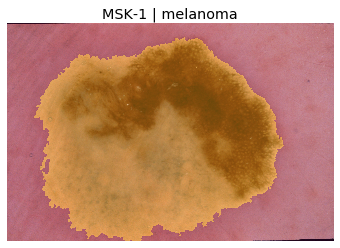

In [28]:
'''
Load one image and one mask
'''
# for train max 3169
index = 2450

# Load image
img_filename = train_dir+'/images'+'/'+mask_info['name'][index]+'.png'
print(img_filename)
img = io.imread(img_filename)

# Load mask
mask_filename = train_dir+'/masks'+'/'+mask_info['name'][index]+'_mask.png'
print(mask_filename)
mask = io.imread(mask_filename)

# Load info
info = ''
info += image_info['dataset_name'][index]
info += ' | '
info += image_info['diagnosis'][index]

show_imgmask(img, mask, title=info)

In [29]:
'''
Create a class for our dataset
'''
class ISICDataset(Dataset):
    '''ISIC images-masks dataset'''
    def __init__(self, images_dir, masks_dir, transform=None):
        '''
        Args:
            imgs_dir (string): Directory with all images
            mask_dir (string): Directory with all masks
            transform (callable, optional): Optional transform to be applied on a sample.
        '''
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
    
    def __len__(self):
        return len(os.listdir(self.masks_dir))
    
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
            
        image_filename = sorted(os.listdir(self.images_dir))[index]
        mask_filename = sorted(os.listdir(self.masks_dir))[index]

        image = io.imread(os.path.join(self.images_dir,image_filename))
        mask = io.imread(os.path.join(self.masks_dir,mask_filename))
        
        sample = {'image': image, 'mask': mask}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample
        

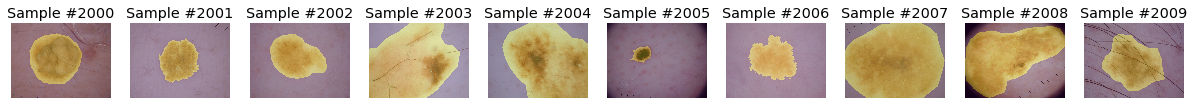

In [32]:
'''
Example of work ISICDataset class
'''
train_isic_dataset = ISICDataset(train_images_dir, train_masks_dir)

n_images = 10

fig, ax = plt.subplots(1,n_images, figsize=(21,12))

for i in range(n_images):
    index = i + 2000
    sample = train_isic_dataset[index]
    
#     print(i, sample['image'].shape, sample['mask'].shape)

    ax[i].set_title('Sample #{}'.format(index))
    ax[i].axis('off')
    show_imgmask(sample['image'], sample['mask'], ax[i])
plt.show()

In [33]:
'''
Creating transforms
'''
class Rescale(object):
    '''Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    '''

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']
        
        h, w = sample['image'].shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))
        msk = transform.resize(mask, (new_h, new_w))
        msk = msk.round()
        
        return {'image': img, 'mask': msk}
    
    
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
    
    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h, left: left + new_w]
        mask = mask[top: top + new_h, left: left + new_w]

        return {'image': image, 'mask': mask}
            
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        
        # .unsqueeze(0)
        return {'image': torch.tensor(image, dtype=torch.float),
                'mask': torch.tensor(np.ceil(mask), dtype=torch.long)}

In [ ]:
'''
Transformation demo
'''
scale = Rescale((100, 100))
crop = RandomCrop(1000)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])
# Apply each of the above transforms on sample.
sample = train_isic_dataset[21]

fig, ax = plt.subplots(1,3, figsize=(12,6))

for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax[i].set_title(type(tsfrm).__name__)
    show_imgmask(transformed_sample['image'], transformed_sample['mask'], ax[i])

plt.show()

In [65]:
'''
Make real generators for dataset
'''
train_set = ISICDataset(train_images_dir, 
                        train_masks_dir,
                        transform=transforms.Compose([
                            Rescale((256,256)),
                            ToTensor()
                        ]))

small_train_set, _ = random_split(train_set, [500, len(train_set)-500])



test_set = ISICDataset(test_images_dir, 
                       test_masks_dir,
                       transform=transforms.Compose([
                           Rescale((256,256)),
                           ToTensor()
                        ]))

# U-net
inspired by https://github.com/choosehappy/PytorchDigitalPathology/tree/master/segmentation_epistroma_unet

In [66]:
from unet import UNet # https://github.com/jvanvugt/pytorch-unet

In [67]:
'''
Parameters for U-net
'''
model_params = {
    'n_classes': 2, # number of calsses in the mask
    'in_channels': 3, # input channals data (rgb: 3)
    'padding': True,
    'depth': 5, # depth of net
    'wf': 2, # number of filters in first layer 2**wf 
    'up_mode': 'upconv', # upsample of interpolation: 'upconv', 'upsample'
    'batch_norm': True # batchnorm beween layers    
}

'''
Parameters for training
'''
batch_size = 1
n_epoch = 10

In [68]:
'''
Prepare device
'''
if(torch.cuda.is_available()):
    print(torch.cuda.get_device_properties(0))
    torch.cuda.set_device(0)
    device = torch.device(f'cuda:{0}')
else:
    device = torch.device(f'cpu')

_CudaDeviceProperties(name='GeForce RTX 2080', major=7, minor=5, total_memory=7979MB, multi_processor_count=46)


In [69]:
'''
Define model, optimizer and loss function
'''
model = UNet(**model_params).to(device)

print('Total params:\t{}'.format(sum([np.prod(p.size()) for p in model.parameters()])))

optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

Total params:	122466


In [70]:
'''
Batch training generator
'''
train_params = {
    'batch_size': batch_size,
    'shuffle': True,
    'num_workers': 12,
    'drop_last': True
}

train_generator = torch.utils.data.DataLoader(small_train_set, **train_params)

In [73]:
from tqdm import tqdm
'''
Train model
'''
threshold_for_prediction = 0.0  # between(-1,1);

for epoch in range(n_epoch):
    for sample in tqdm(train_generator):
        count += 1
        img, msk = sample['image'].to(device), sample['mask'].to(device) 
    
        # forward
        y_pred = model(img)

        # loss
        loss = criterion(y_pred, msk) 

        # update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(loss.item())

  0%|          | 0/500 [00:00<?, ?it/s]

0.21069550514221191


 86%|████████▌ | 431/500 [03:38<00:58,  1.19it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67a2c729e0>
Traceback (most recent call last):
  File "/home/ivan/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/home/ivan/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/home/ivan/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67a2c729e0>
Traceback (most recent call last):
  File "/home/ivan/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/home/ivan/anaconda3/lib/python3.7/site-packages/torch/utils/data/d

0.6265277862548828


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67a2c729e0>
Traceback (most recent call last):
  File "/home/ivan/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67a2c729e0>
  File "/home/ivan/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/home/ivan/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
  File "/home/ivan/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join
    self._shutdown_workers()
    assert self._parent_pid == os.getpid(), 'can only join a child process'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67a2c729e0>
  File "/home/ivan/anaconda3/lib/python3.7/site-packages/torch/utils/data/datalo

0.2194378823041916


 14%|█▍        | 71/500 [00:44<08:41,  1.21s/it] Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67a2c729e0>
Traceback (most recent call last):
  File "/home/ivan/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/home/ivan/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/home/ivan/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67a2c729e0>
Traceback (most recent call last):
  File "/home/ivan/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/home/ivan/anaconda3/lib/python3.7/site-packages/torch/utils/data/d

0.23293966054916382


  0%|          | 0/500 [00:00<?, ?it/s]

0.32599908113479614


  0%|          | 0/500 [00:00<?, ?it/s]

0.17640022933483124


  0%|          | 0/500 [00:00<?, ?it/s]

0.41185739636421204


  0%|          | 0/500 [00:00<?, ?it/s]

0.22333458065986633


 25%|██▍       | 124/500 [01:33<04:43,  1.33it/s]


KeyboardInterrupt: 

In [ ]:
n_train_imgs = len(os.listdir(train_images_dir))
model_weights_path = './models/unet_weights_{}_{}_{}.pth'.format(model_params['depth'], n_epoch, n_train_imgs)
model_params_path = './models/unet_params_{}_{}_{}.json'.format(model_params['depth'], n_epoch, n_train_imgs) 

content = json.dumps(model_params) 
f = open(model_params_path, 'w')
f.write(content)
f.close()

torch.save(model.state_dict(), model_weights_path)

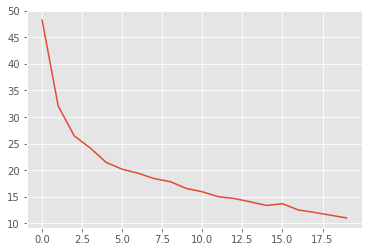

In [200]:
plt.plot(total_loss)

## Test U-net

In [109]:
# Load model
model_name = '5_10_3169'

f = open('./models/unet_params_'+model_name+'.json')
model_params = json.load(f)
f.close()

model = UNet(**model_params).to(device)
model.load_state_dict(torch.load('./models/unet_weights_'+model_name+'.pth'))

<All keys matched successfully>

In [75]:
'''
(DSC) Sørensen–Dice coefficient
'''
def torch_dice(output, target):
    # Dice loss: 1 - dice score
    # 0 - same; 1 - different
    intersection = torch.mul(output, target)
#     print('output.sum:',output.sum())
#     print('target.sum:',target.sum())
#     print('intersection.sum:',intersection.sum().item())

    union = (torch.add(output, target) > 0).long()
#     print('union.unique:',union.unique())
#     print('union.sum:',union.sum().item())

    dice = torch.div(intersection.sum().float(), union.sum().float())
#     print('Dice:',dice.item())
    return torch.add(1, -dice)

In [80]:
image_info

,isic_name,isic_id,age_approx,anatom_site_general,benign_malignant,clin_size_long_diam_mm,diagnosis,diagnosis_confirm_type,family_hx_mm,mel_class,mel_thick_mm,melanocytic,nevus_type,personal_hx_mm,sex,dataset_name
0,ISIC_0000000,5436e3abbae478396759f0cf,55.0,anterior torso,benign,NaN,nevus,NaN,NaN,NaN,NaN,True,NaN,NaN,female,UDA-1
1,ISIC_0000001,5436e3acbae478396759f0d1,30.0,anterior torso,benign,NaN,nevus,NaN,NaN,NaN,NaN,True,NaN,NaN,female,UDA-1
2,ISIC_0000002,5436e3acbae478396759f0d3,60.0,upper extremity,malignant,NaN,melanoma,histopathology,NaN,NaN,NaN,True,NaN,NaN,female,UDA-1
3,ISIC_0000003,5436e3acbae478396759f0d5,30.0,upper extremity,benign,NaN,nevus,NaN,NaN,NaN,NaN,True,NaN,NaN,male,UDA-1
4,ISIC_0000004,5436e3acbae478396759f0d7,80.0,posterior torso,malignant,NaN,melanoma,histopathology,NaN,NaN,NaN,True,NaN,NaN,male,UDA-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14650,ISIC_0034317,5aaf162711659769136471fb,70.0,lower extremity,malignant,NaN,melanoma,histopathology,NaN,NaN,NaN,True,NaN,NaN,female,HAM10000
14651,ISIC_0034318,5aaf16271165976913647206,55.0,NaN,NaN,NaN,pigmented benign keratosis,histopathology,NaN,NaN,NaN,False,NaN,NaN,male,HAM10000
14652,ISIC_0034319,5aaf16271165976913647214,30.0,NaN,benign,NaN,nevus,histopathology,NaN,NaN,NaN,True,NaN,NaN,male,HAM10000
14653,ISIC_0034320,5aaf16271165976913647223,25.0,anterior torso,benign,NaN,nevus,histopathology,NaN,NaN,NaN,True,NaN,NaN,female,HAM10000


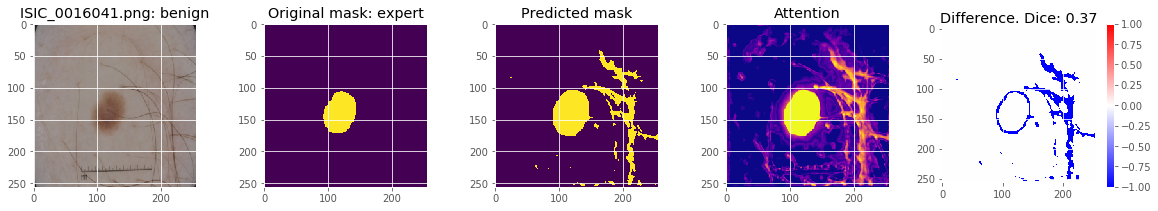

In [86]:
# Easy: 1128 1132 1135 1141
# Hard: 1181 1127 1131 1133
threshold_for_prediction = 0.0
index = 50
mask_index = 1

sample = test_set[index] 
image, mask = sample['image'], sample['mask']

# load masks
img = image.unsqueeze(0).to(device)
mask = mask.to(device)

# predict mask
y_pred = model(img)

# compute dice
output = y_pred[-1][mask_index]
output = (output > threshold_for_prediction).long()
target = mask
dice = torch_dice(output, target)

# info about image
diagnosis = image_info['benign_malignant'][index]
img_name = os.listdir(test_images_dir)[index]

# get true image and mask
true_img = image.detach().numpy().transpose(1,2,0)
true_mask = mask.detach().cpu().numpy()

# get predicted mask
pred_mask = y_pred.squeeze(0).clone()
pred_mask = pred_mask.detach().cpu().numpy().transpose(1,2,0)
npred_mask = np.array((pred_mask > threshold_for_prediction), dtype='int')

# plot
fig, ax = plt.subplots(1, 5, figsize=(20,3))

ax[0].imshow(true_img)
ax[0].set_title(img_name+': '+diagnosis)
ax[1].imshow(true_mask)
ax[1].set_title('Original mask: {}'.format(mask_info['skill'][index]))
ax[2].imshow(npred_mask[:,:,mask_index])
ax[2].set_title('Predicted mask')
ax[3].imshow(pred_mask[:,:,mask_index], 'plasma', vmin=-1,vmax=1)
ax[3].set_title('Attention')
im = ax[4].imshow(true_mask - npred_mask[:,:,mask_index], 'bwr', vmin=-1,vmax=1)
ax[4].set_title('Difference. Dice: {:2.2f}'.format(1 - dice.item()))
plt.colorbar(im)
plt.show()

In [174]:

# output = y_pred[-1][1]
# target = mask

# output = (output > 0).long()

# # print('intersection:', torch.mul(output))

# a1 = (output.detach().cpu().numpy() > 0.999).astype(float)
# a2 = (output.detach().cpu().numpy() > 0).astype(float)

# b1 = target.detach().cpu().numpy()

# print(torch_dice(output, target))

# p_mask = y_pred.detach().squeeze(0).cpu().numpy().transpose(1,2,0)[:,:,1]
# np_mask = (p_mask - p_mask.min()) / (p_mask.max() - p_mask.min())
# # Plot
# fig, ax = plt.subplots(1,4, figsize=(16,16))
# ax[0].imshow(b1)
# ax[0].set_title('Original mask')
# ax[1].imshow(a1)
# ax[1].set_title('threshold 0.999')
# ax[2].imshow(a2)
# ax[2].set_title('threshold 0')
# ax[3].imshow(true_img)
# ax[3].imshow(np_mask, 'plasma')
# ax[3].grid('')

# plt.show()

In [180]:
'''
TEST
'''
total_dice_score = 0.0
threshold_for_prediction = 0.0 # between(-1,1); try: 0 and 0.999

with torch.no_grad():
    for i in range(907): # 907 test images
        sample = test_set[i]
        image, mask = sample['image'], sample['mask']

        # [N, 3, H, W] - image
        # [N, H, W] - mask with classes (0, 1)
        img = image.unsqueeze(0).to(device)
        msk = mask.unsqueeze(0).to(device)

        y_pred = model(img)
        
        # Compute Dice
        output = y_pred[-1][1]
        target = msk[-1]

        output = (output > threshold_for_prediction).long()
        
        dice = torch_dice(output, target)
        total_dice_score += dice.item()
        
        if i % 10 == 9:
            print(i, total_dice_score / i)

print('-'*25)
print('0 - same; 1 - different')    
print('Total test dice loss: {:2.6f}'.format(total_dice_score / 500))
